<a href="https://colab.research.google.com/github/israt-tabassum/AirQuality_Univariate/blob/main/PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


epoch,train_loss,valid_loss,mae,time
0,0.003379,0.521104,0.071845,03:46
1,0.002638,2.102626,0.180101,03:42
2,0.002560,0.391671,0.057228,03:46
3,0.001566,0.068517,0.076293,03:45
4,0.000089,0.001866,0.005529,03:42
5,0.000158,2.871590,0.131941,03:37
6,0.000301,0.006558,0.014991,03:41
7,0.000124,0.131682,0.037065,03:37
8,0.000248,0.029006,0.025032,03:36
9,0.000059,0.025501,0.019569,03:39


Validation MAE: 0.0196


Validation RMSE: 23917392.4371


Predicted next 10 values: [-1131328.5]


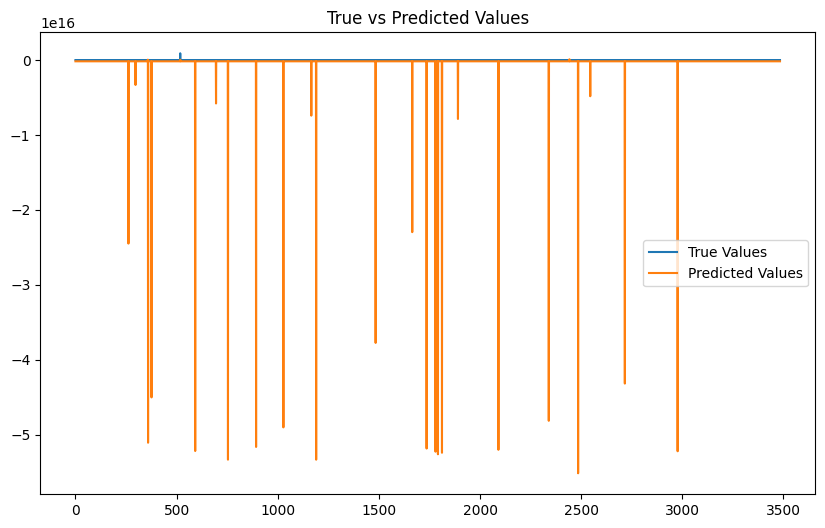

In [4]:
# Install necessary packages (uncomment if needed)
!pip install tsai
!pip install pandas scikit-learn numpy matplotlib

# Required Libraries
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the data
df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start', 'End'])

# Filter and preprocess data
df = df[['Start', 'Value']].sort_values(by='Start')
scaler = MinMaxScaler()
df['Value'] = scaler.fit_transform(df[['Value']])

# Extract the values for modeling
values = df['Value'].values

# Create time series dataset using `tsai`'s SlidingWindow
sequence_length = 100  # Number of steps in each input sequence
X, y = SlidingWindow(window_len=sequence_length, horizon=1)(values)  # Corrected argument name

# Generate train-test split indices using `RandomSplitter`
splits = RandomSplitter(valid_pct=0.2)(range_of(X))  # Automatically create splits

# Convert to DataLoaders for tsai
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=32)

# Define the model (e.g., InceptionTimePlus)
model = InceptionTimePlus(c_in=1, c_out=1)

# Create a Learner
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=mae)

# Train the model
learn.fit_one_cycle(10, lr_max=1e-3)

# Validate the model
valid_mae = learn.validate()[1]
print(f"Validation MAE: {valid_mae:.4f}")

# Evaluate RMSE on the validation set
preds, targs = learn.get_preds(ds_idx=1)
y_valid_pred = preds.numpy()
y_valid_true = targs.numpy()
y_valid_pred = scaler.inverse_transform(y_valid_pred)
y_valid_true = scaler.inverse_transform(y_valid_true.reshape(-1, 1))
rmse = sqrt(mean_squared_error(y_valid_true, y_valid_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Predict future steps
future_steps = 10
last_seq = values[-sequence_length:].reshape(1, sequence_length)  # Reshape for prediction
preds = learn.get_X_preds(torch.tensor(last_seq).unsqueeze(1).float())[0]  # Adjust for tsai's method
preds = scaler.inverse_transform(preds.numpy())

print(f"Predicted next {future_steps} values: {preds.flatten()}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_valid_true), label='True Values')
plt.plot(scaler.inverse_transform(y_valid_pred), label='Predicted Values')
plt.legend()
plt.title("True vs Predicted Values")
plt.show()
